In [1]:
import os

In [2]:
!pwd

/home/jovyan/notebooks/analysis/regression-siso


In [3]:
import sys
sys.path.append('/home/jovyan/')

In [4]:
from experiments.reporting.report_repository import ReportRepository
from experiments.slack_client import SlackNotifier
from neat.neat_logger import get_neat_logger
from neat.population_engine import EvolutionEngine
from neat.reporting.reports_pyneat import EvolutionReport
from neat.utils import timeit
import math
import random
from itertools import count
import numpy as np

from experiments.logger import logger
from experiments.slack_client import Notifier
from experiments.object_repository.object_repository import ObjectRepository
from experiments.reporting.report_repository import ReportPathFactory
from neat.configuration import get_configuration
from neat.evaluation.evaluation_engine import EvaluationStochasticEngine
from neat.evolution_operators.crossover import Crossover
from neat.evolution_operators.mutation import Mutation
from neat.genome import Genome
from neat.reporting.reports_pyneat import EvolutionReport
from neat.species import SpeciationEngine
from neat.stagnation import Stagnation
from neat.population_engine import PopulationEngine
from neat.utils import timeit
import neat
import tests
from config_files.configuration_utils import create_configuration
from neat.configuration import get_configuration, set_configuration
from neat.evaluation.evaluation_engine import get_dataset
from neat.evaluation.evaluate_simple import evaluate_genome, calculate_prediction_distribution
from neat.genome import Genome
import os
from neat.loss.vi_loss import get_loss
import torch
import pandas as pd

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from neat.analysis.experiment_data import ExperimentData
from neat.analysis.uncertainty.predictive_distribution import PredictionDistributionEstimator
from neat.analysis.plotting.plot_losses import plot_loss_distribution

In [7]:
LOGS_PATH = f'{os.getcwd()}/'
logger = get_neat_logger(path=LOGS_PATH)

In [8]:
PROJECT = 'neuro-evolution'
ALGORITHM_VERSION = 'bayes-neat'
DATASET = 'regression-siso'
correlation_ids = ['neat_5_regression-siso', 'bayesian_neat_5_regression-siso']

In [9]:
experiment_data = ExperimentData(correlation_ids=correlation_ids, dataset_name=DATASET, n_samples=1000,
                                 project=PROJECT, algorithm_version=ALGORITHM_VERSION)\
                    .process_data()
data = experiment_data.get_experiment_data()
# data.head()

###########
CORRELATION ID: neat_5_regression-siso
Fitness of best individual: -0.5359451770782471
0.5
Training: 2500. Testing: 2500
Fitness of best individual: -0.42859798669815063
0.5
Training: 2500. Testing: 2500
Fitness of best individual: -0.4918052852153778
0.5
Training: 2500. Testing: 2500
Fitness of best individual: -0.5034981369972229
0.5
Training: 2500. Testing: 2500
1
0.001
###########
CORRELATION ID: bayesian_neat_5_regression-siso
Fitness of best individual: -0.4736672639846802
0.5
Training: 2500. Testing: 2500
Fitness of best individual: -0.4148789644241333
0.5
Training: 2500. Testing: 2500
Fitness of best individual: -0.5556508302688599
0.5
Training: 2500. Testing: 2500
Fitness of best individual: -0.42846202850341797
0.5
Training: 2500. Testing: 2500
0
0.001


In [10]:
data

,correlation_id,execution_id,train_percentage,is_bayesian,beta,loss_training,loss_testing,duration,end_condition,n_parameters,n_nodes,n_connections,mean_genome_std,mse,mae
0,neat_5_regression-siso,74f6cc4a-b143-442a-9b12-cfb54292354d,0.5,False,0.001,0.535945,10.538103,0:00:59.318970,normal,42,8,13,0.000619,15.044965,3.076513
0,neat_5_regression-siso,8bbec50e-aeac-488d-825a-bc1357bc018d,0.5,False,0.001,0.428598,8.770840,0:00:56.544117,normal,34,6,11,0.000647,14.893402,3.059872
0,neat_5_regression-siso,adad27ca-caf4-4831-a030-9814536ceed1,0.5,False,0.001,0.491805,6.406881,0:00:58.638358,normal,28,5,9,0.000715,14.930067,3.065043
0,neat_5_regression-siso,e91debc4-b85c-4d93-9a2f-387f7812fe86,0.5,False,0.001,0.503498,10.295403,0:00:42.879162,normal,32,6,10,0.000688,14.863675,3.056794
0,bayesian_neat_5_regression-siso,23a5ee8b-a7c5-4f74-b1d1-b7b0829e2c2b,0.5,True,0.001,0.473667,8.698267,0:13:09.685469,normal,58,10,19,0.250484,15.354521,3.108382
0,bayesian_neat_5_regression-siso,5bc96304-a05e-45ab-b29a-42f4530a7576,0.5,True,0.001,0.414879,7.747811,0:11:49.594357,normal,34,7,10,0.298782,15.106265,3.082237
0,bayesian_neat_5_regression-siso,767941e4-b563-4ab8-8619-7b51f3576bc7,0.5,True,0.001,0.555651,3.777476,0:14:57.330757,normal,48,9,15,0.242823,14.893426,3.060677
0,bayesian_neat_5_regression-siso,c32b0fe8-c4fd-4ae7-8aa9-c23f5bd387eb,0.5,True,0.001,0.428462,4.952810,0:14:21.378763,normal,50,9,16,0.224008,15.427958,3.115018


In [15]:
execution_ids = data.loc[data['is_bayesian'] ==1, 'execution_id'].values.tolist()
chunks = []
for execution_id in execution_ids:
    print(execution_id)
# execution_id = 'd5610c88-22fd-45b1-8438-0110601597df' # bayes-neat
# execution_id = '078e79d4-fbc9-4663-8716-92f49365ce39' # neat
    genome = experiment_data.best_genomes[execution_id]
    config = experiment_data.configurations[execution_id]
    predictor = PredictionDistributionEstimator(genome=genome, config=config, testing=True)\
                .estimate()\
                .enrich_with_dispersion_quantile()\
                .calculate_metrics_by_dispersion_quantile(log=False)
    metrics_by_dispersion_quantile = predictor.metrics_by_quantile
    metrics_by_dispersion_quantile['execution_id'] = execution_id
    chunks.append(metrics_by_dispersion_quantile)
    
metrics_by_dispersion_quantile = pd.concat(chunks, sort=False, ignore_index=True)
metrics_by_dispersion_quantile.head()

23a5ee8b-a7c5-4f74-b1d1-b7b0829e2c2b
Training: 2500. Testing: 2500
5bc96304-a05e-45ab-b29a-42f4530a7576
Training: 2500. Testing: 2500
767941e4-b563-4ab8-8619-7b51f3576bc7
Training: 2500. Testing: 2500
c32b0fe8-c4fd-4ae7-8aa9-c23f5bd387eb
Training: 2500. Testing: 2500


,order_std,mse,mae,execution_id
0,10,8.028036,2.249297,23a5ee8b-a7c5-4f74-b1d1-b7b0829e2c2b
1,11,8.031127,2.249968,23a5ee8b-a7c5-4f74-b1d1-b7b0829e2c2b
2,12,8.027953,2.249268,23a5ee8b-a7c5-4f74-b1d1-b7b0829e2c2b
3,13,8.031167,2.250096,23a5ee8b-a7c5-4f74-b1d1-b7b0829e2c2b
4,14,8.033609,2.250438,23a5ee8b-a7c5-4f74-b1d1-b7b0829e2c2b


In [12]:
metrics_by_dispersion_quantile = predictor.metrics_by_quantile
metrics_by_dispersion_quantile.head()

,order_std,mse,mae,execution_id
0,10,4.802931,1.772437,c32b0fe8-c4fd-4ae7-8aa9-c23f5bd387eb
1,11,4.804043,1.772576,c32b0fe8-c4fd-4ae7-8aa9-c23f5bd387eb
2,12,4.805741,1.772982,c32b0fe8-c4fd-4ae7-8aa9-c23f5bd387eb
3,13,4.803335,1.772374,c32b0fe8-c4fd-4ae7-8aa9-c23f5bd387eb
4,14,4.801435,1.771846,c32b0fe8-c4fd-4ae7-8aa9-c23f5bd387eb


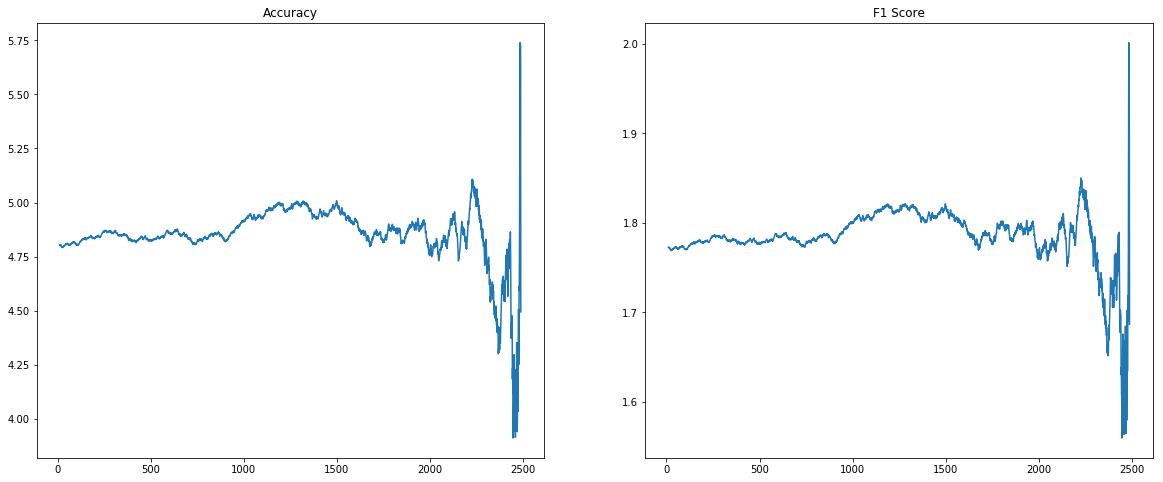

In [14]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
for execution_id, metrics_by_execution_id in metrics_by_dispersion_quantile.groupby('execution_id'):

    ax1.plot(metrics_by_execution_id['order_std'], metrics_by_execution_id['mse'])
    ax1.set_title('Accuracy')
    # ax1.set_x

    ax2.plot(metrics_by_execution_id['order_std'], metrics_by_execution_id['mae'])
    ax2.set_title('F1 Score')
plt.show()

Text(0.5, 1.0, 'F1 Score')

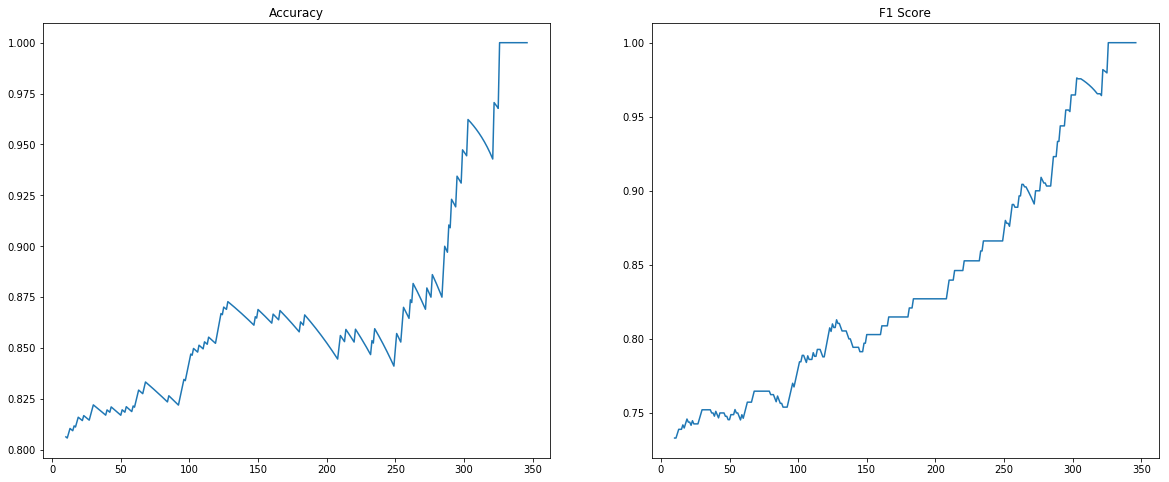

In [13]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.plot(metrics_by_dispersion_quantile['order_std'], metrics_by_dispersion_quantile['accuracy'])
ax1.set_title('Accuracy')
# ax1.set_x

ax2.plot(metrics_by_dispersion_quantile['order_std'], metrics_by_dispersion_quantile['f1'])
ax2.set_title('F1 Score')

In [66]:
# experiment_data.best_genomes

In [224]:
execution_id = '7c07e559-d01c-48b2-ad5b-fd89c417e12b' # bayes-neat
# execution_id = '078e79d4-fbc9-4663-8716-92f49365ce39' # neat
genome = experiment_data.best_genomes[execution_id]
config = experiment_data.configurations[execution_id]
set_configuration(config)
dataset = get_dataset(config.dataset, train_percentage=config.train_percentage, testing=True)
print(config.fix_std)

Training: 214. Testing: 500
1


In [225]:
x, y_true, output_distribution = calculate_prediction_distribution(genome=genome, dataset=dataset, problem_type=config.problem_type, is_testing=True, n_samples=1000)
y_pred = torch.argmax(output_distribution.mean(1), 1)
output_means = output_distribution.mean(1)
output_stds = output_distribution.std(1)[:, 0]
min_ = torch.min(output_distribution, 1).values
max_ = torch.max(output_distribution, 1).values
output_range = (max_ - min_)[:, 0]
output_distribution.shape

torch.Size([500, 1000, 2])

In [226]:
results = pd.DataFrame({'y_pred': y_pred.numpy(),
                        'y_true': y_true.numpy(),
                        'std': output_stds.numpy(),
                       'range': output_range.numpy()}).reset_index().rename(columns={'index': 'example_id'})
results['correct'] = False
results.loc[(results['y_true'] == results['y_pred']), 'correct'] = True
results.head(1)

,example_id,y_pred,y_true,std,range,correct
0,0,0,0,0.0,0.0,True


In [227]:
# n_points = 60
# results['std_quantiles'] = pd.qcut(results['std'], q=n_points)
results.head()

,example_id,y_pred,y_true,std,range,correct
0,0,0,0,0.000000e+00,0.000000e+00,True
1,1,0,1,0.000000e+00,0.000000e+00,False
2,2,1,1,1.155844e-07,7.674098e-07,True
3,3,1,1,3.158432e-10,1.760782e-09,True
4,4,0,1,0.000000e+00,0.000000e+00,False


In [228]:
std_quantiles = results[['example_id', 'std']]\
                .sort_values('std', ascending=False)\
                .reset_index(drop=True)\
                .reset_index()\
                .rename(columns={'index': 'order_std'})\
                .drop('std', axis=1)
std_quantiles.head()

In [229]:
results = results.merge(std_quantiles, on='example_id')
results

,example_id,y_pred,y_true,std,range,correct,order_std
0,0,0,0,0.000000e+00,0.000000e+00,True,161
1,1,0,1,0.000000e+00,0.000000e+00,False,471
2,2,1,1,1.155844e-07,7.674098e-07,True,508
3,3,1,1,3.158432e-10,1.760782e-09,True,152
4,4,0,1,0.000000e+00,0.000000e+00,False,238
...,...,...,...,...,...,...,...
495,495,1,0,5.444764e-10,4.190952e-09,False,240
496,496,0,0,2.820679e-08,1.788139e-07,True,30
497,497,1,1,1.741859e-13,1.133316e-12,True,154
498,498,0,1,1.220294e-06,7.629395e-06,False,442


In [230]:
metrics_by_quantile = []
for i in range(10, len(results) -10):
    results_filtered = results.loc[results['order_std'] > i]
    
    mean_std = np.mean(results_filtered['std'].values)
    
    print(f'Mean dispersion: {mean_std} for {len(results_filtered)} points')
    accuracy = accuracy_score(results_filtered['y_true'], results_filtered['y_pred'])
    f1 = f1_score(results_filtered['y_true'], results_filtered['y_pred'])
    metrics_by_quantile.append([i, accuracy, f1])
    
df_metrics_by_quantile = pd.DataFrame(metrics_by_quantile, columns=['order_std', 'accuracy', 'f1'])
df_metrics_by_quantile

Mean dispersion: 6.741714031477386e-08 for 489 points
Mean dispersion: 6.755529824431505e-08 for 488 points
Mean dispersion: 6.76940175026175e-08 for 487 points
Mean dispersion: 6.783330519510855e-08 for 486 points
Mean dispersion: 6.783330519510855e-08 for 486 points
Mean dispersion: 6.797301921324106e-08 for 485 points
Mean dispersion: 6.811345798496404e-08 for 484 points
Mean dispersion: 6.825447940173035e-08 for 483 points
Mean dispersion: 6.839608346353998e-08 for 482 points
Mean dispersion: 6.757881010344136e-08 for 481 points
Mean dispersion: 6.771959704110486e-08 for 480 points
Mean dispersion: 6.786097372923905e-08 for 479 points
Mean dispersion: 6.800293306241656e-08 for 478 points
Mean dispersion: 6.811692543351455e-08 for 477 points
Mean dispersion: 6.811692543351455e-08 for 477 points
Mean dispersion: 6.809348462866183e-08 for 476 points
Mean dispersion: 6.822565978836792e-08 for 475 points
Mean dispersion: 6.833948873463669e-08 for 474 points
Mean dispersion: 6.8299790711

,order_std,accuracy,f1
0,10,0.799591,0.759804
1,11,0.799180,0.759804
2,12,0.798768,0.759804
3,13,0.798354,0.759804
4,14,0.798354,0.759804
...,...,...,...
475,485,0.786667,0.741935
476,486,0.797297,0.754098
477,487,0.794521,0.754098
478,488,0.791667,0.745763


In [213]:
df_metrics_by_quantile.head()

,order_std,accuracy,f1
0,10,0.798214,0.729017
1,11,0.797853,0.729017
2,12,0.797491,0.729017
3,13,0.797127,0.729017
4,14,0.798561,0.730769


Text(0.5, 1.0, 'F1 Score')

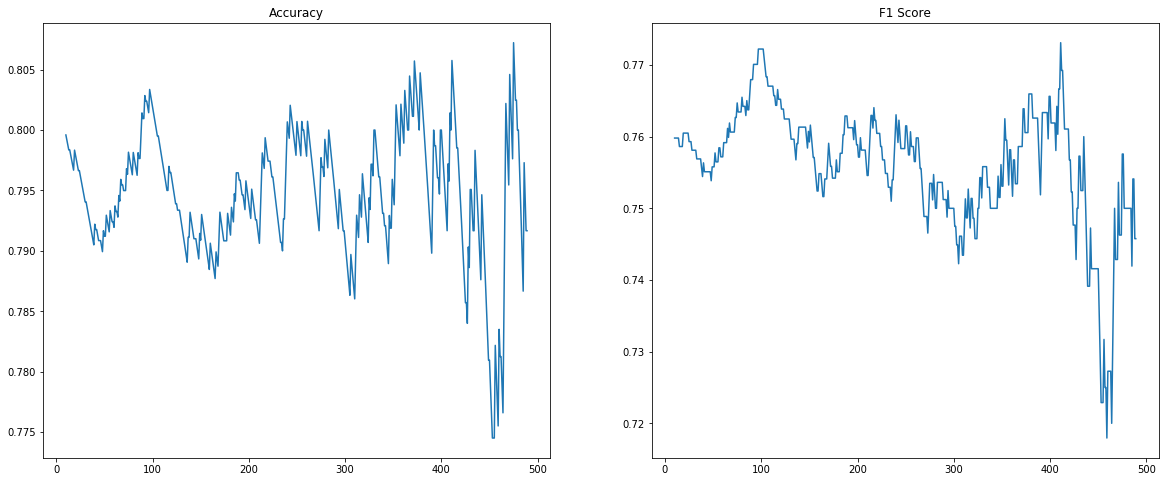

In [231]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.plot(df_metrics_by_quantile['order_std'], df_metrics_by_quantile['accuracy'])
ax1.set_title('Accuracy')
# ax1.set_x

ax2.plot(df_metrics_by_quantile['order_std'], df_metrics_by_quantile['f1'])
ax2.set_title('F1 Score')

In [17]:
sns.boxplot(data=results, x='correct', y='std')
plt.show()

sns.boxplot(data=results, x='correct', y='range')
plt.show()

NameError: name 'results' is not defined

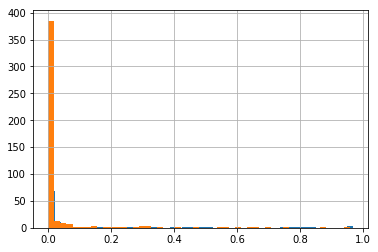

In [174]:
ax = results[results['correct'] == False]['range'].hist(bins=50)
results[results['correct'] == True]['range'].hist(bins=50, ax=ax)

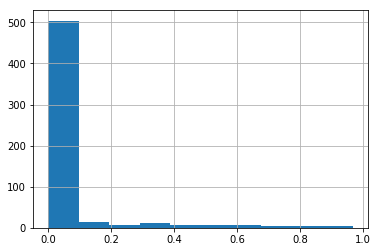

In [165]:
results['range'].hist()

tensor([4.3367e-03, 7.1526e-07, 2.9802e-07, 4.6712e-03, 2.0526e-04, 3.9672e-03,
        0.0000e+00, 4.7684e-07, 6.7870e-05, 7.1607e-02, 5.0391e-01, 4.4108e-02,
        4.9310e-05, 4.5603e-04, 5.9605e-08, 5.7180e-05, 1.6689e-06, 4.7684e-07,
        5.9605e-08, 6.8367e-05, 6.7035e-04, 5.9605e-08, 1.0073e-05, 7.1524e-02,
        1.4139e-02, 8.2850e-06, 1.4004e-04, 8.6427e-06, 3.9707e-03, 1.5009e-03,
        6.0057e-01, 2.3961e-05, 5.1113e-05, 3.7304e-03, 7.5698e-05, 8.5297e-03,
        0.0000e+00, 1.1716e-03, 1.3828e-05, 5.8146e-02, 3.9518e-05, 6.4303e-02,
        1.6005e-03, 1.0729e-06, 1.0490e-05, 5.2904e-02, 1.5787e-02, 1.5438e-05,
        4.6872e-08, 4.8397e-02, 2.4416e-03, 4.5084e-03, 2.0206e-05, 1.1921e-06,
        3.4690e-05, 4.5371e-01, 2.3000e-07, 1.7327e-03, 2.0862e-06, 5.4162e-01,
        1.7309e-04, 1.1921e-07, 7.4530e-01, 1.1661e-01, 5.2045e-05, 5.4933e-05,
        1.9570e-04, 8.9407e-07, 8.7559e-05, 1.0468e-02, 1.0056e-03, 1.1921e-07,
        2.3842e-07, 5.0947e-05, 4.2252e-

In [159]:
# torch.max(range_[:, 0] - range_[:, 1])

tensor(1.1921e-07)

In [137]:
output_stds

tensor([[5.1189e-04, 5.1189e-04],
        [3.9797e-08, 3.2402e-08],
        [2.8450e-08, 2.7017e-08],
        ...,
        [5.9268e-06, 5.9302e-06],
        [2.5640e-02, 2.5640e-02],
        [9.4337e-08, 9.0773e-08]])

In [134]:
accuracy_score(results['y_true'], results['y_pred'])

0.7898423817863398

In [76]:
display(output_distribution.shape)
n_examples = len(y_true)
n_classes = output_distribution.shape[2]
n_classes

torch.Size([571, 1000, 2])

2

In [72]:
index_sample

426

In [120]:
def plot_prediction_probabilities(output_distribution, y_true, y_pred, output_means, output_stds, index_to_plot):
    nbins = 50
    output_distribution_example = output_distribution[index_to_plot]
    y_true_example = y_true.numpy()[index_to_plot]
    y_pred_example = y_pred.numpy()[index_to_plot]
    
    std = output_stds.numpy()[index_to_plot]
    
    print(f'True -> {y_true_example}')
    print(f'Predicted -> {y_pred_example}')
    print(f'STDS: {std}')
    
    _, axes = plt.subplots(1, 2, figsize=(15, 8))
    for label in range(n_classes):
    # ax1.plot(x, y)
        ax = axes[label]
        ax.set_title(f'Probability Distribution of label {label}')
        array_label = np.round(output_distribution_example[:, label].numpy(), 5)
        ax.hist(array_label, bins=_bins_generator(array=array_label, nbins=nbins));

    plt.show()
    
    
    
def _bins_generator(array, nbins):
    min_ = np.min(array)
    max_ = np.max(array)
    bin_size = (max_ - min_) / nbins
    
    acc = min_
    bins = [acc]
    for i in range(nbins + 1):
        
        acc += bin_size
        bins.append(acc)
    return bins
    

True -> 0
Predicted -> 0
STDS: [7.864277e-07 7.857936e-07]


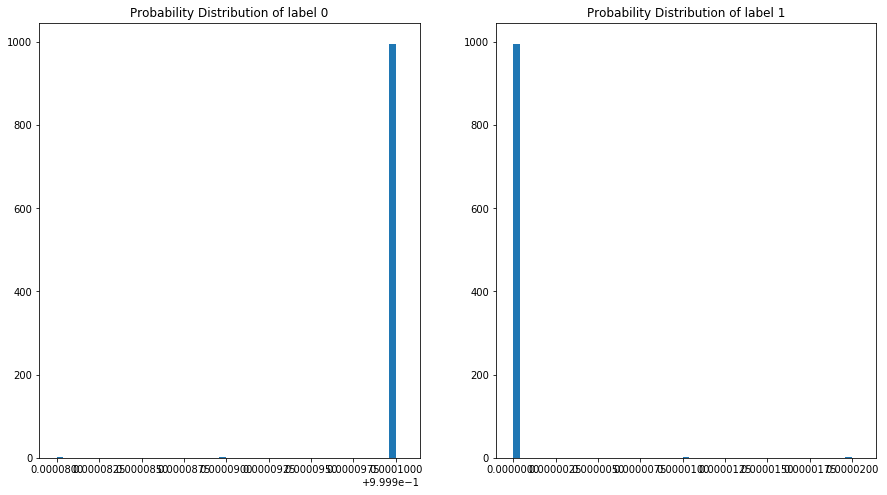

In [129]:
index_sample = np.random.choice(tuple(range(n_examples)), replace=False, size=1)[0]
plot_prediction_probabilities(output_distribution, y_true, y_pred, output_means, output_stds, index_to_plot=index_sample)

In [125]:
output_distribution[index_sample]

tensor([[1.0000e+00, 1.6691e-08],
        [1.0000e+00, 1.7899e-08],
        [1.0000e+00, 2.3722e-08],
        ...,
        [1.0000e+00, 1.7057e-08],
        [1.0000e+00, 1.3185e-08],
        [1.0000e+00, 1.8513e-08]])

torch.Size([571, 2])

NameError: name 'n_classes' is not defined

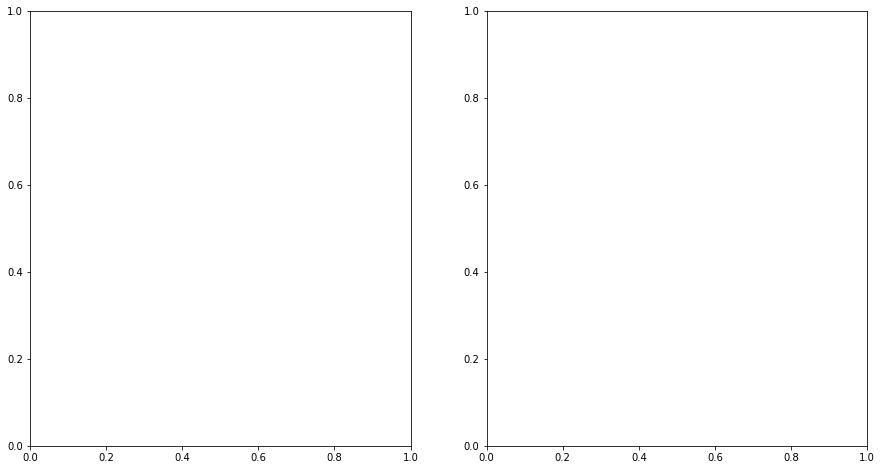

In [75]:
index_sample = np.random.choice(tuple(range(n_examples)), replace=False, size=1)[0]
nbins = 50

y_true_example = y_true.numpy()[index_sample]


f, (axes) = plt.subplots(1, 2, figsize=(15, 8))
for label in range(n_classes):
# ax1.plot(x, y)
    ax.set_title(f'Probability Distribution of label {array_label}')
    array_label = np.round(output_distribution[index_sample][:, label].numpy(), 5)
    ax.hist(array_label, bins=_bins_generator(array=array_label, nbins=nbins));

# ax2.set_title('Probability Distribution of laber 1')
# ax2.hist(output_distribution[index_sample][:, 1].numpy(), bins=50);

In [55]:
array_0

array([0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298,
       0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298,
       0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298,
       0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298,
       0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298,
       0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298,
       0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298,
       0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298,
       0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298,
       0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298,
       0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298,
       0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298,
       0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298,
       0.92297, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298, 0.92298,
       0.92298, 0.92

In [32]:
plt.hist??

Signature:
plt.hist(
    x,
    bins=None,
    range=None,
    density=None,
    weights=None,
    cumulative=False,
    bottom=None,
    histtype='bar',
    align='mid',
    orientation='vertical',
    rwidth=None,
    log=False,
    color=None,
    label=None,
    stacked=False,
    normed=None,
    *,
    data=None,
    **kwargs,
)
Docstring:
Plot a histogram.

Compute and draw the histogram of *x*. The return value is a
tuple (*n*, *bins*, *patches*) or ([*n0*, *n1*, ...], *bins*,
[*patches0*, *patches1*,...]) if the input contains multiple
data.

Multiple data can be provided via *x* as a list of datasets
of potentially different length ([*x0*, *x1*, ...]), or as
a 2-D ndarray in which each column is a dataset.  Note that
the ndarray form is transposed relative to the list form.

Masked arrays are not supported at present.

Parameters
----------
x : (n,) array or sequence of (n,) arrays
    Input values, this takes either a single array or a sequence of
    arrays which are not re

In [19]:
def show_probability_distributions(distribution):
#     plt.figure(figsize=(15, 8))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    ax1.plot(x, y)
    ax1.set_title('Sharing Y axis')
    

tensor([[[0.9982, 0.0018],
         [0.9975, 0.0025],
         [0.9981, 0.0019],
         ...,
         [0.9985, 0.0015],
         [0.9978, 0.0022],
         [0.9978, 0.0022]],

        [[0.1233, 0.8767],
         [0.1241, 0.8759],
         [0.1240, 0.8760],
         ...,
         [0.1222, 0.8778],
         [0.1234, 0.8766],
         [0.1235, 0.8765]],

        [[0.2243, 0.7757],
         [0.2334, 0.7666],
         [0.1991, 0.8009],
         ...,
         [0.1955, 0.8045],
         [0.2099, 0.7901],
         [0.1926, 0.8074]],

        ...,

        [[0.0165, 0.9835],
         [0.0095, 0.9905],
         [0.0156, 0.9844],
         ...,
         [0.0103, 0.9897],
         [0.0135, 0.9865],
         [0.0121, 0.9879]],

        [[0.8114, 0.1886],
         [0.7555, 0.2445],
         [0.8021, 0.1979],
         ...,
         [0.7239, 0.2761],
         [0.6879, 0.3121],
         [0.7753, 0.2247]],

        [[0.0318, 0.9682],
         [0.0321, 0.9679],
         [0.0310, 0.9690],
         ...,
 

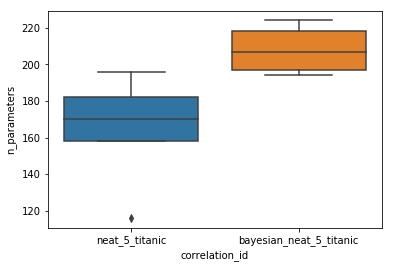

In [18]:
sns.boxplot(data=data, y='n_parameters', x='correlation_id')

In [162]:
x, y_true, y_pred, loss_value = evaluate_genome(genome=genome,
                                                        dataset=dataset,
                                                        loss=loss,
                                                        problem_type=config.problem_type,
                                                        beta_type=config.beta_type,
                                                        batch_size=config.batch_size,
                                                        n_samples=10,
                                                        is_gpu=config.is_gpu,
                                                        is_testing=False,
                                                        return_all=True)
loss_value

0.010836866684257984

In [119]:
y_pred.shape

torch.Size([1057, 2])

In [76]:
get_mean_std(genome)

0.18159483528429712

In [120]:
genome.calculate_number_of_parameters()

180

In [36]:
report.data['end_condition']

'normal'

In [18]:
data

,correlation_id,execution_id,train_percentage,loss_training,loss_testing,duration,end_condition,n_parameters,n_nodes,n_connections,mean_genome_std,accuracy,f1
0,neat_5_titanic,016b46d3-fb7d-49cf-919b-8df83550094a,0.5,0.475380,0.502783,0:03:36.210397,normal,116,18,40,0.000742,80.112045,0.739927
0,neat_5_titanic,0f08d432-4dd5-4d8b-bfb0-0e0b29a29543,0.5,0.466678,0.501078,0:09:38.486948,normal,196,31,67,0.000704,78.431373,0.698039
0,neat_5_titanic,605da818-fd4d-442e-ada7-703c400f4fb6,0.5,0.472681,0.496458,0:10:38.173538,normal,170,27,58,0.000706,80.672269,0.733591
0,neat_5_titanic,85a9fdd0-9417-4f91-8cbc-991577567dbb,0.5,0.478143,0.492955,0:05:34.611607,normal,158,25,54,0.000722,79.271709,0.710938
0,neat_5_titanic,d56ab404-5d95-494f-87e6-60697b016844,0.5,0.469560,0.498205,0:13:23.014596,normal,182,29,62,0.000704,80.672269,0.729412
0,bayesian_neat_5_titanic,3baa6852-43b8-41fe-9284-3476cee9fb7f,0.5,0.471491,0.509299,0:21:26.501442,normal,198,32,67,0.215566,77.871148,0.718861
0,bayesian_neat_5_titanic,40e23ac4-951a-46f5-8fb9-e3f748c17ac6,0.5,0.471478,0.494067,0:21:35.192112,normal,194,31,66,0.166282,80.392157,0.748201
0,bayesian_neat_5_titanic,733fb299-a581-4e84-8112-e49873629c4c,0.5,0.468936,0.503598,0:20:59.477343,normal,224,36,76,0.221448,79.831933,0.739130
0,bayesian_neat_5_titanic,d5610c88-22fd-45b1-8438-0110601597df,0.5,0.474083,0.512381,0:36:26.650240,normal,216,35,73,0.245311,80.112045,0.727969


In [20]:
# report.data

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
loss_data = pd.melt(data, id_vars=['correlation_id', 'execution_id', 'is_bayesian', 'train_percentage'], value_vars=['loss_training', 'loss_testing'], var_name='type', value_name='loss')
loss_data.head(1)

,correlation_id,execution_id,is_bayesian,train_percentage,type,loss
0,neat_5_titanic,016b46d3-fb7d-49cf-919b-8df83550094a,False,0.5,loss_training,0.47538


In [12]:
data

<bound method ExperimentData.get_experiment_data of <neat.analysis.experiment_data.ExperimentData object at 0x7f0bfa546c50>>

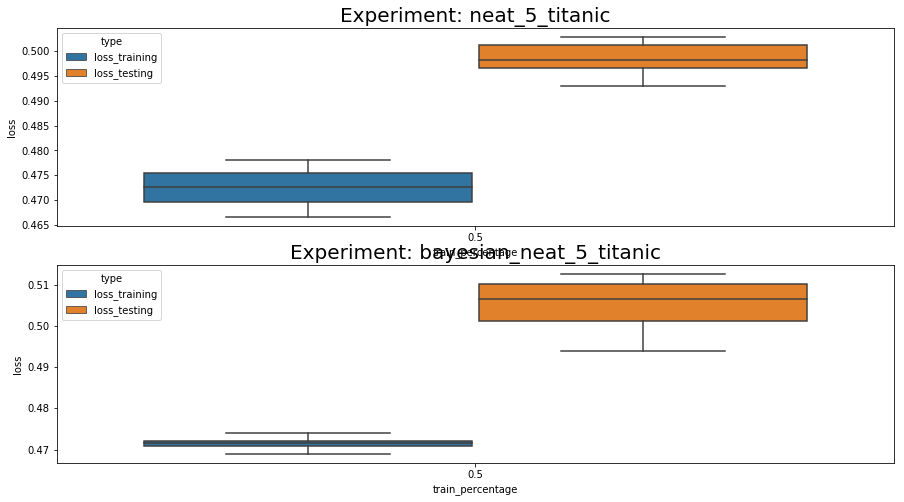

In [20]:
plot_loss_distribution(data)

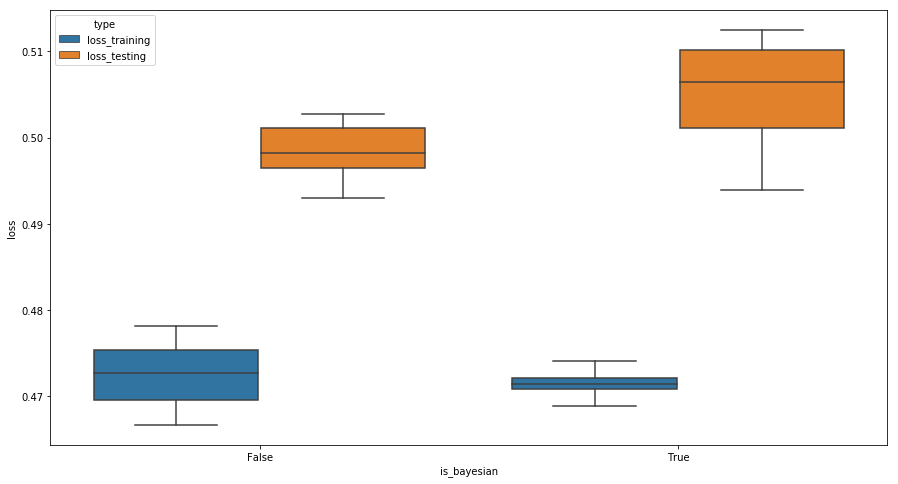

In [23]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=loss_data, x='is_bayesian', y='loss', hue='type')

Text(0.5, 1.0, 'Loss Testing')

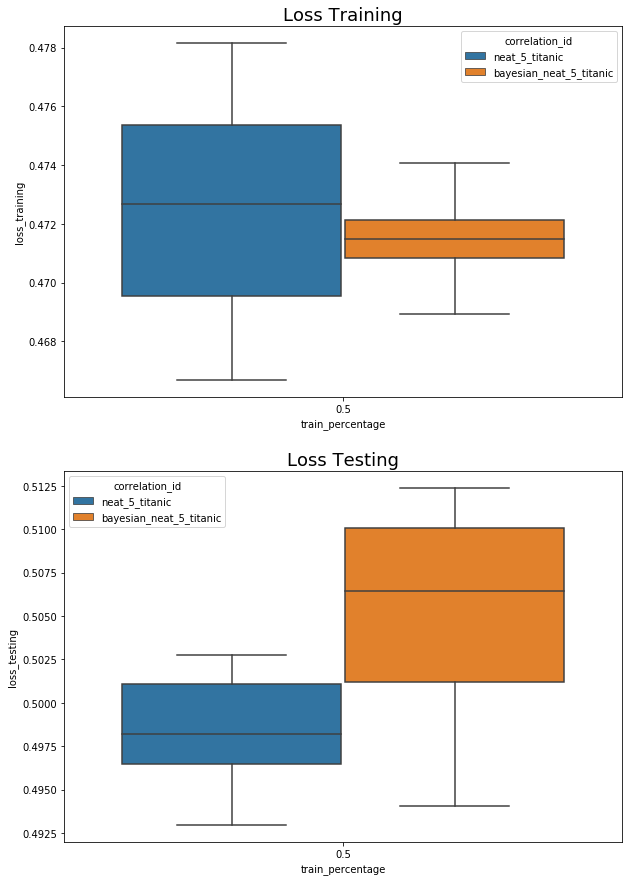

In [13]:
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 15))
sns.boxplot(data=data, x='train_percentage', y='loss_training', hue='correlation_id', ax=ax1)
ax1.set_title('Loss Training', fontsize=18)

sns.boxplot(data=data, x='train_percentage', y='loss_testing', hue='correlation_id', ax=ax2)
ax2.set_title('Loss Testing', fontsize=18)


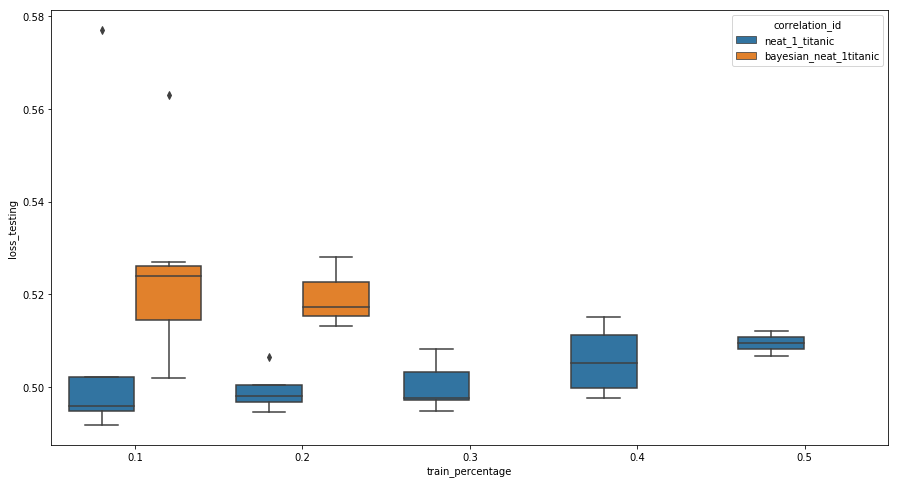

In [108]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=data, x='train_percentage', y='loss_testing', hue='correlation_id')

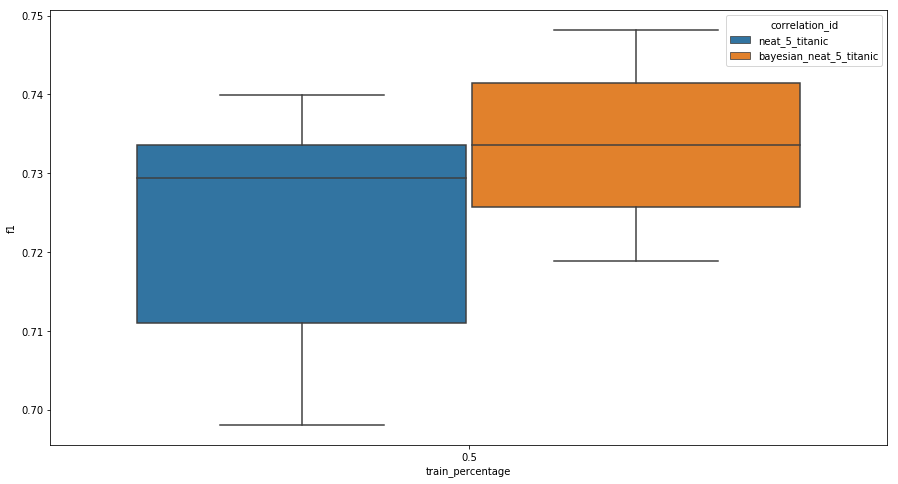

In [14]:
plt.figure(figsize=(15, 8))
ax = sns.boxplot(data=data, x='train_percentage', y='f1', hue='correlation_id')
# ax.set_ylim([0.50, 1.10])
# sns.boxplot(data=data, x='correlation_id', y='f1')

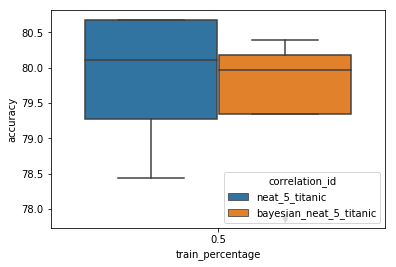

In [15]:
# plt.figure(figsize=(15, 8))
sns.boxplot(data=data, x='train_percentage', y='accuracy', hue='correlation_id')
# ax = sns.boxplot(data=data, x='correlation_id', y='accuracy')
# ax.set_ylim([50, 110])

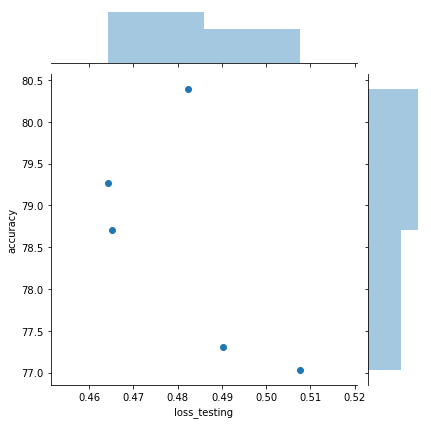

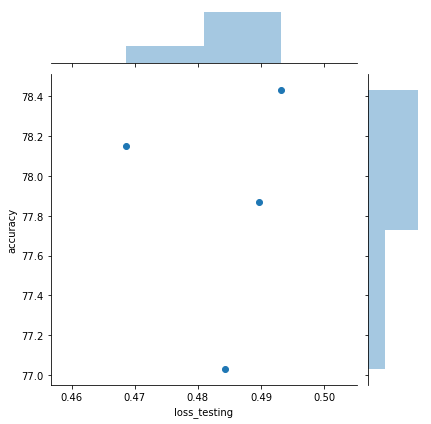

In [27]:
fd = data.loc[data['correlation_id'] == 'neat']
sns.jointplot(fd['loss_testing'], fd['accuracy'])
plt.show()

fd = data.loc[data['correlation_id'] == 'bayesian_neat']
sns.jointplot(fd['loss_testing'], fd['accuracy'])
plt.show()

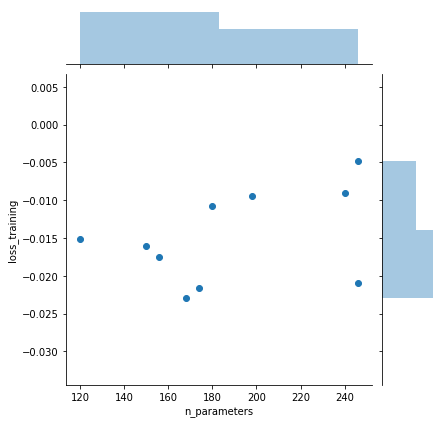

In [128]:
sns.jointplot(data['n_parameters'], data['loss_training'])
plt.show()

In [189]:
n_samples = 50
n_output = 2

x, y_true, y_pred, loss_value = evaluate_genome(genome=genome,
                                                dataset=dataset,
                                                loss=loss,
                                                problem_type=config.problem_type,
                                                beta_type=config.beta_type,
                                                batch_size=config.batch_size,
                                                n_samples=n_samples,
                                                is_gpu=config.is_gpu,
                                                is_testing=True,
                                                return_all=True)
# y_pred = torch.argmax(y_pred, dim=1)
# multinomial = convert_to_multinomial(y_pred, n_samples, n_output)
# y_pred = torch.argmax(multinomial, dim=1)

# n_examples = y_true.shape[0] // n_samples
# y_true = y_true[:n_examples]


In [160]:
multinomial

tensor([[0., 1.],
        [0., 1.],
        [0., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 0.],
        [1., 0.],
        [1., 0.],
        [0., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 0.],
        [1

In [194]:
a = y_pred.reshape(n_samples, -1,  n_output).permute(1, 0, 2)
a.shape

torch.Size([286, 50, 2])

In [170]:
sum_ = a.sum(2)
a[:, :, 0] = a[:, :, 0] / sum_
a[:, :, 1] = a[:, :, 1] / sum_

In [204]:
b.shape

torch.Size([286, 50, 2])

In [192]:
b = a.mean(1)
sum_ = b.sum(1)
b[:, 0] = b[:, 0] / sum_
b[:, 1] = b[:, 1] / sum_
b

tensor([[ 0.1103,  0.8897],
        [ 0.2868,  0.7132],
        [ 0.3174,  0.6826],
        [ 0.2262,  0.7738],
        [ 0.0780,  0.9220],
        [-0.1404,  1.1404],
        [ 0.0826,  0.9174],
        [-0.2693,  1.2693],
        [ 0.3232,  0.6768],
        [ 0.3259,  0.6741],
        [ 0.2707,  0.7293],
        [-0.0182,  1.0182],
        [ 0.4088,  0.5912],
        [-0.1039,  1.1039],
        [ 0.3069,  0.6931],
        [ 0.1944,  0.8056],
        [ 0.5346,  0.4654],
        [-0.4886,  1.4886],
        [ 0.2802,  0.7198],
        [-0.0815,  1.0815],
        [ 0.0783,  0.9217],
        [ 0.4486,  0.5514],
        [-0.3360,  1.3360],
        [-0.2867,  1.2867],
        [ 0.4097,  0.5903],
        [ 0.2651,  0.7349],
        [ 0.0760,  0.9240],
        [ 0.0301,  0.9699],
        [ 0.2193,  0.7807],
        [ 0.2073,  0.7927],
        [-0.2520,  1.2520],
        [ 0.0875,  0.9125],
        [ 0.1792,  0.8208],
        [-0.0824,  1.0824],
        [ 0.2695,  0.7305],
        [-0.0524,  1

In [107]:
multinomial = convert_to_multinomial(y_pred, n_samples, n_output)

In [115]:
y_pred = torch.argmax(multinomial, dim=1)

In [118]:
n_examples = y_true.shape[0] // n_samples
y_true = y_true[:n_examples]
y_true.shape

torch.Size([428])

In [125]:
accuracy_score(y_true, y_pred) * 100

77.57009345794393

In [78]:
y_pred_permuted = y_pred.reshape(n_samples, -1,  n_output).permute(1, 0, 2)
y_pred_permuted.shape

torch.Size([428, 10, 2])

In [93]:
(torch.argmax(y_pred_permuted, dim=2) == 0).sum(1).shape

torch.Size([428])

In [67]:
y_pred_2

tensor([[1, 1, 0,  ..., 1, 0, 0],
        [1, 1, 0,  ..., 1, 0, 0],
        [1, 1, 0,  ..., 1, 0, 0],
        ...,
        [1, 1, 0,  ..., 1, 0, 0],
        [1, 1, 0,  ..., 1, 0, 0],
        [1, 1, 0,  ..., 1, 0, 0]])

In [46]:
y_pred.shape

torch.Size([4280, 2])

In [58]:
torch.argmax(y_pred.reshape(n_samples, 428,  n_output), dim=2).shape

torch.Size([10, 428])

In [29]:
(y_true[:428] - y_true[428:]

tensor(0)

In [37]:
y_true.reshape(n_samples, 428)

tensor([[1, 0, 0,  ..., 1, 1, 0],
        [1, 0, 0,  ..., 1, 1, 0],
        [1, 0, 0,  ..., 1, 1, 0],
        ...,
        [1, 0, 0,  ..., 1, 1, 0],
        [1, 0, 0,  ..., 1, 1, 0],
        [1, 0, 0,  ..., 1, 1, 0]])

In [31]:
y_pred.reshape(428, 2, 2)

tensor([[[ 0.8290,  4.2379],
         [ 1.0596,  1.9037]],

        [[ 0.6045, -1.7164],
         [ 0.3472, -1.2161]],

        [[ 1.5991,  1.6905],
         [ 1.0347, -1.6860]],

        ...,

        [[ 1.2464, -1.2299],
         [ 3.9550,  2.1523]],

        [[ 1.2926, -0.6405],
         [ 1.5285,  4.4967]],

        [[ 1.3371,  0.5004],
         [ 0.9608, -1.7886]]])

In [103]:

# execution_id = '03070516-99e6-40ab-9b69-1764807a3adb'


CORRELATION_ID = 'test'

In [104]:
# execution_id = '2014fc1f-50e0-42b8-800e-69102967c77f' # -0.22
# DATASET = 'mnist_binary'
# ALGORITHM_VERSION = 'bayes-neat'
# CORRELATION_ID = 'test'

In [105]:
report_repository = ReportRepository.create(project='neuro-evolution', logs_path=LOGS_PATH)
report = report_repository.get_report(algorithm_version=ALGORITHM_VERSION,
                                      dataset=DATASET,
                                      correlation_id=CORRELATION_ID,
                                      execution_id=execution_id)

In [106]:
genome_dict = report.data['best_individual']
best_individual_fitness = report.data['best_individual_fitness']
print(f'Fitness of best individual: {best_individual_fitness}')

genome = Genome.from_dict(genome_dict)
config = genome.genome_config
set_configuration(config)

Fitness of best individual: -2.3697526454925537


## Show graph

In [107]:
from neat.plotting.plot_network import plot_genome_network

In [108]:
display(plot_genome_network(genome))

In [109]:
# genome_dict

In [110]:
loss = get_loss(problem_type=config.problem_type)
dataset = get_dataset(config.dataset, testing=True)

In [117]:
x, y_true, y_pred, loss_value = evaluate_genome(genome=genome,
                                                    dataset=dataset,
                                                    loss=loss,
                                                    problem_type=config.problem_type,
                                                    beta_type=config.beta_type,
                                                    batch_size=config.batch_size,
                                                    n_samples=1,
                                                    is_gpu=config.is_gpu,
                                                    return_all=True)
print(y_true)
y_pred

tensor([7, 2, 1,  ..., 4, 5, 6])


tensor([[-2.6890, -2.0346,  0.6964,  ..., -0.9401, -0.9440,  0.9615],
        [ 2.5225, -2.8846,  1.5552,  ...,  0.6954,  0.1857, -4.0237],
        [-0.3499,  2.6887, -1.7241,  ...,  3.7133, -0.2113, -2.0000],
        ...,
        [-3.2037,  2.0330, -2.7131,  ...,  1.3300, -0.0857,  1.9407],
        [-0.3025,  2.6943, -1.7036,  ...,  3.7501, -0.2097, -2.0593],
        [ 2.5739, -2.8736,  1.5741,  ...,  0.7363,  0.1865, -4.0924]])

In [123]:
loss_value

2.369753122329712

In [118]:
x.shape

torch.Size([10000, 256])

In [119]:
y_true.shape

torch.Size([10000])

In [120]:
y_pred.shape

torch.Size([10000, 10])

In [122]:
for connection in genome_dict['connection_genes'].values():
#     connection['_weight_std'] = 0.000000001
    value = connection['_weight_std']
    value = connection['_weight_mean']

    print(value)

1.7278531514591198
1.480095555043142
-0.1746260370396398
-1.734405598095528
2.0
1.3677152509761004
0.22731100455084852
-2.0
1.5321293006855448
-0.8476895072309275
-1.1705173870712136
1.8142093890732123
-0.05691644986882578
-1.4904733490144964
-1.31868141699613
-0.18636462772663037
-0.16044850381954287
-1.0883101043361407
-1.4933373890235908
-0.7512856757862271
0.013804253623737328
-1.233543939591855
1.1527165071172938
0.027434074457697744
-0.5271935859197234
-2.0
-0.053561851338297384
-1.931878536003712
1.7875924034843877
-1.5408401292424307
-1.1093673333484333
-0.1259589419472338
-1.363082579560478
1.0084378985916735
0.25163041617326737
-0.25105949446414116
-1.130910856247755
-0.450113934248467
1.9974217433258121
-1.725966302693073
2.0
1.5820946063914012
0.44443812084306666
1.4434844762581167
-2.0
0.5971135566012571
-0.7916792372260617
1.1430336564590768
0.07629138467145702
0.3605110507770068
-1.0485686077371796
0.80506787820727
0.19720481312414484
0.963767473976989
-0.610823225518168

In [53]:
for connection in genome_dict['node_genes'].values():
    value = connection['_bias_std']
#     connection['_bias_std'] = 0.000000001
    print(value)

0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001


In [118]:
genome_dict['node_genes']

{'0': {'key': 0,
  'activation': 'tanh',
  'aggregation': 'sum',
  '_bias_mean': 0.8057251123197042,
  '_bias_std': 0.001},
 '1': {'key': 1,
  'activation': 'tanh',
  'aggregation': 'sum',
  '_bias_mean': 1.0,
  '_bias_std': 0.001},
 '2': {'key': 2,
  'activation': 'tanh',
  'aggregation': 'sum',
  '_bias_mean': 1.0,
  '_bias_std': 0.001},
 '3': {'key': 3,
  'activation': 'tanh',
  'aggregation': 'sum',
  '_bias_mean': -1.0,
  '_bias_std': 0.001},
 '4': {'key': 4,
  'activation': 'tanh',
  'aggregation': 'sum',
  '_bias_mean': -0.34778403774296407,
  '_bias_std': 0.001},
 '5': {'key': 5,
  'activation': 'tanh',
  'aggregation': 'sum',
  '_bias_mean': -0.3556845272430937,
  '_bias_std': 0.001},
 '6': {'key': 6,
  'activation': 'tanh',
  'aggregation': 'sum',
  '_bias_mean': 1.0,
  '_bias_std': 0.001},
 '7': {'key': 7,
  'activation': 'tanh',
  'aggregation': 'sum',
  '_bias_mean': -0.1276673725763255,
  '_bias_std': 0.001},
 '8': {'key': 8,
  'activation': 'tanh',
  'aggregation': 'sum'

In [9]:
config_file = 'mnist_downsampled'
config = create_configuration(filename=f'/{config_file}.json')

In [13]:
# TODO: better mechanism for override
config.pop_size = 20
# config.n_samples = 50
#
config.n_generations = 300
config.node_add_prob = 0.5
config.n_output = 2
config.n_processes = 2


ALGORITHM_VERSION = 'bayes-neat'
DATASET = 'mnist_binary'
# CORRELATION_ID = 'parameters_grid'
CORRELATION_ID = 'solve_binary'

In [14]:
report_repository = ReportRepository.create(project='neuro-evolution', logs_path=LOGS_PATH)
notifier = SlackNotifier.create(channel='batch-jobs')

In [15]:
report = EvolutionReport(report_repository=report_repository,
                         algorithm_version=ALGORITHM_VERSION,
                         dataset=DATASET,
                         correlation_id=CORRELATION_ID)

In [16]:
population_engine = PopulationEngine(stagnation_engine=Stagnation())
speciation_engine = SpeciationEngine()
evaluation_engine = EvaluationStochasticEngine()

GETTING DATASET
GETTING DATASET


In [17]:
evaluation_engine.n_processes

2

### Initialize

In [18]:
end_condition = 'normal'
# try:
# initialize population
population = population_engine.initialize_population()
speciation_engine.speciate(population, generation=0)

population = evaluation_engine.evaluate(population=population)

# report
report.report_new_generation(generation=0,
                                  population=population,
                                  species=speciation_engine.species)

2020-03-19 18:15:03,708 - INFO - Generation 0. Best fitness: -198.308. N-Parameters Best: 8
2020-03-19 18:15:03,709 - INFO -                          Mean fitness: -199.773. Mean N-Parameters: 8.0
2020-03-19 18:15:03,710 - INFO -     New best individual (20) found with fitness -198.308
GETTING DATASET
Confusion Matrix:
[[48435 49565]
 [56598 56902]]
Accuracy: 49.8047281323877 %


In [22]:
def run_generation(generation, population):
    
    # create new generation's population
    population = population_engine.reproduce(species=speciation_engine.species,
                                             pop_size=population_engine.pop_size,
                                             generation=generation)
    # create new species based on new population
    speciation_engine.speciate(population, generation=generation)

    # evaluate
    population = evaluation_engine.evaluate(population=population)

    # generation report
    report.report_new_generation(generation=generation,
                                 population=population,
                                 species=speciation_engine.species)
    generation += 1
    return population

In [23]:
generation = 1

In [27]:
generation += 1
population = run_generation(generation, population)

2020-03-20 09:39:33,083 - INFO - Generation 3. Best fitness: -0.956. N-Parameters Best: 24
2020-03-20 09:39:33,083 - INFO -                          Mean fitness: -21.167. Mean N-Parameters: 22.8


### Check evaluation results

In [31]:
from neat.evaluation.evaluate_simple import evaluate_genome
from neat.evaluation.utils import get_dataset
from neat.loss.vi_loss import get_loss, get_beta

In [29]:
testing = False

In [33]:
dataset = get_dataset(config.dataset, testing=testing)
loss = get_loss(problem_type=config.problem_type)

GETTING DATASET
